# Effect of Substitution Matrices

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)
df_uniprot_human_seqs = pd.read_sql(f"SELECT Sequence FROM proteins WHERE Entry IN (SELECT uniprot_accession FROM uniref50_distilled)", conn)
conn.close()
# filtered_sequences = df_uniprot_human_seqs[
#     (df_uniprot_human_seqs["Sequence"].str.count("X") <= 1) &
#     (df_uniprot_human_seqs["Sequence"].str.count("B") <= 1) &
#     (df_uniprot_human_seqs["Sequence"].str.count("U") <= 1) &
#     (df_uniprot_human_seqs["Sequence"].str.count("Z") <= 1)
# ]["Sequence"].tolist()
filtered_sequences = df_uniprot_human_seqs["Sequence"].tolist()
print(len(filtered_sequences))


70901


In [41]:
# Connect to DB
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)

uniref_id = '50'
df_protein = pd.read_sql(f"""SELECT Entry as uniprot_id, Sequence as sequence
                          FROM proteins
                          WHERE Entry IN (SELECT uniprot_accession FROM uniref{uniref_id}_distilled)""", conn)
df_protein = df_protein[df_protein['sequence'].str.len() < 3000].reset_index(drop=True)

df_interpro_domain = pd.read_sql(f"SELECT uniprot_id, interpro_id as source, start_index, end_index FROM interpro_entries_v2 WHERE type='domain'", conn)
df_ted = pd.read_sql(f"SELECT uniprot_id, ted_id as source, start_index, end_index FROM ted_entries_summary WHERE plddt >= 70", conn)

conn.close()

df_domains = pd.concat([df_interpro_domain, df_ted])
interpro_ids = df_domains.loc[df_domains["source"].str.startswith("IPR"), "uniprot_id"].unique() # Find uniprot_ids that have "interpro" as a source
df_domains = df_domains[~((df_domains["uniprot_id"].isin(interpro_ids)) & (df_domains["source"].str.startswith("AF")))] # Filter the DataFrame to exclude rows with source "ted" for those uniprot_ids
df_domains = df_protein.set_index('uniprot_id').join(df_domains.set_index('uniprot_id'), how='inner').reset_index()
df_domains['domain_sequence'] = df_domains.apply(lambda row: row['sequence'][row['start_index']-1: row['end_index']], axis=1)
df_domains = df_domains[df_domains['domain_sequence'].str.len()>0].reset_index(drop=True)
filtered_sequences = df_domains['domain_sequence']

In [4]:
# 'dataset': {'uniref50', 'uniref90'}
# 'is_pretokenizer': {True, False}
# 'subs_matrix': {'blosum45', 'blosum62', 'pam70', 'pam250'}
# 'mutation_cutoff': {0.7, 0.8, 0.9}
# 'min_mutation_freq': {0, 0.05,. 0.005}
# 'min_mutation_len': {3}
# 'max_mutation_len': {12}
# 'vocab_size': list=[800, 1600, 3200, 6400, 12800, 25600, 51200]

# vocab_sizes = [800, 1600, 3200, 6400, 12800]
vocab_sizes = [800, 1600, 3200, 6400, 12800, 25600, 51200]
uniref_id = "50"

def generate_tokenizer_opts(final_list, pretokenizeds, matrices):
    for pre in pretokenizeds:
        for matr in matrices:
            final_list.append(
                {
                'is_mut': True,
                'dataset': f'uniref{uniref_id}',
                'is_pretokenizer': pre,
                'subs_matrix': matr,
                'mutation_cutoff': 0.7 if matr != "pam250" else 0.8,
                'min_mutation_freq': 0.05,
                'min_mutation_len': 3,
                'max_mutation_len': 12,
                'vocab_size': vocab_sizes
                }
            )


tokenizer_opts_list = [
    {
        'is_mut': False,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'vocab_size': vocab_sizes
    },
]
generate_tokenizer_opts(tokenizer_opts_list, [False], ["pam250", "pam70", "blosum45", "blosum62"])

Load the tokenizers for vocabularies generated from various substitution matrices

In [5]:
import vocabulary_functions as vf
tokenizer_list = vf.load_tokenizers(tokenizer_opts_list)
print(list(tokenizer_list.keys())[:10])


['stdBPE 800', 'stdBPE 1600', 'stdBPE 3200', 'stdBPE 6400', 'stdBPE 12800', 'stdBPE 25600', 'stdBPE 51200', 'mutBPE pam250 0.8 0.05 800', 'mutBPE pam250 0.8 0.05 1600', 'mutBPE pam250 0.8 0.05 3200']


In [6]:
import vocabulary_functions as vf


encoded_list = {k: v.encode_batch(filtered_sequences) for k, v in tokenizer_list.items()}


Calculate the dice coefficient for threemer encodings

In [49]:
from statistics import mean, stdev
threeMer_dice = []
for size in vocab_sizes:
    encoded = encoded_list[f"stdBPE {size}"]
    vals = []
    for enc in encoded:
        idx_list = [o[0] for o in enc.offsets]
        seq_length = enc.offsets[-1][-1]
        idx_list.append(seq_length)
        three_mer_idx_list = list(range(0, seq_length+1, 3))
        vals.append(vf.calc_dice_idx_only((idx_list, three_mer_idx_list)))
    threeMer_dice.append(mean(vals))

In [18]:
agreement_data = {}
for k, v in encoded_list.items():
    if k.startswith("stdBPE"): continue
    stdbpe = encoded_list[f"stdBPE {k.split()[-1]}"]
    agreement_data[k] = vf.calc_dice_batch_encoding((v, stdbpe))

In [12]:
sns.set()
sns.color_palette("Spectral", as_cmap=True)

colors = ['olivedrab', 'lightseagreen', 'slateblue', 'gold', 'cornflowerblue', 'darkred']
markers = ["o--", "d--", "*--", "X--", "P--", "p--"]
linestyles = ['-', '--', '-.', ':', "."]

label_pad = 6
title_pad = 15
title_size = 16
tick_size = 14

plt.rcParams["figure.figsize"] = (12, 8)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=19)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=13)
plt.rcParams['figure.dpi'] = 100

figures_folder_name = 'figures'

['mutBPE pam250 0.8 0.05 800', 'mutBPE pam70 0.7 0.05 800', 'mutBPE blosum45 0.7 0.05 800', 'mutBPE blosum62 0.7 0.05 800']
['mutBPE pam250 0.8 0.05 1600', 'mutBPE pam70 0.7 0.05 1600', 'mutBPE blosum45 0.7 0.05 1600', 'mutBPE blosum62 0.7 0.05 1600']
['mutBPE pam250 0.8 0.05 3200', 'mutBPE pam70 0.7 0.05 3200', 'mutBPE blosum45 0.7 0.05 3200', 'mutBPE blosum62 0.7 0.05 3200']
['mutBPE pam250 0.8 0.05 6400', 'mutBPE pam70 0.7 0.05 6400', 'mutBPE blosum45 0.7 0.05 6400', 'mutBPE blosum62 0.7 0.05 6400']
['mutBPE pam250 0.8 0.05 12800', 'mutBPE pam70 0.7 0.05 12800', 'mutBPE blosum45 0.7 0.05 12800', 'mutBPE blosum62 0.7 0.05 12800']
['mutBPE pam250 0.8 0.05 25600', 'mutBPE pam70 0.7 0.05 25600', 'mutBPE blosum45 0.7 0.05 25600', 'mutBPE blosum62 0.7 0.05 25600']
['mutBPE pam250 0.8 0.05 51200', 'mutBPE pam70 0.7 0.05 51200', 'mutBPE blosum45 0.7 0.05 51200', 'mutBPE blosum62 0.7 0.05 51200']
[[0.9215304366981364, 0.8861252120504193, 0.8434041611761047, 0.8038634164559525, 0.766834957068

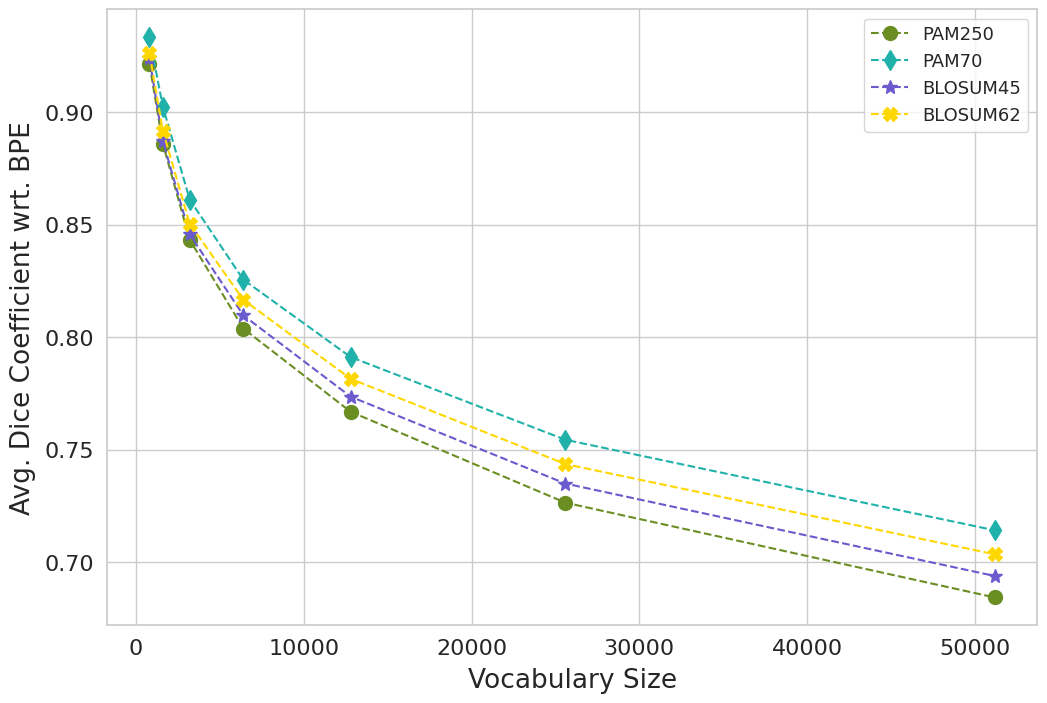

In [20]:


labels = ["PAM250", "PAM70", "BLOSUM45", "BLOSUM62", "3-Mer"] # add threemer here
labels = ["PAM250", "PAM70", "BLOSUM45", "BLOSUM62"] # add threemer here

num_labels = len(labels)

agg_values = []
for i in range(num_labels):
    agg_values.append([])

for size in vocab_sizes:
    names = [n for n in agreement_data.keys() if n.split()[-1] == str(size)]
    print(names)
    for i, n in enumerate(names):
        agg_values[i].append(agreement_data[n][0])

# agg_values[-1] = threeMer_dice
print(agg_values)




sns.set_style("whitegrid")





for i in range(num_labels):
    plt.plot(vocab_sizes, agg_values[i], markers[i], color=colors[i], markersize=10, label=labels[i])


# plt.title(f"Shared Token Percentage Change of Vocab Sizes Between BPE and WordPiece", pad=title_pad, size=13)
plt.legend()
# plt.ylim(top=1, bottom=0)
plt.xticks()
plt.yticks()
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Avg. Dice Coefficient wrt. BPE", labelpad=label_pad);
# plt.savefig(f'{figures_folder_name}/shared_token_percent_plot.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/shared_token_percent_plot.png', bbox_inches='tight')
plt.show()


Generate heatmap

In [7]:
from itertools import combinations
from statistics import mean, stdev
import vocabulary_functions as vf
import numpy as np

labels = ["BPE", "PAM250", "PAM70", "BLOSUM45", "BLOSUM62", "3-MER"]
labels = ["BPE", "PAM250", "PAM70", "BLOSUM45", "BLOSUM62", "RANDOM"]

def label_to_name(l):
    names = [k for k in tokenizer_list if "51200" in k]
    if l == "BPE":
        return "stdBPE 51200"
    for n in names:
        if l.lower() in n:
            return n


pairwise_agreements = {}

# Calculate pairwise dice coefficient values and fill the dictionary
for l1, l2 in combinations(labels, 2):
    if l2 == "3-MER": # Special case for three mer tokenization
        n1 = label_to_name(l1)
        encoded = encoded_list[n1]
        vals = []
        for enc in encoded:
            idx_list = [o[0] for o in enc.offsets]
            seq_length = enc.offsets[-1][-1]
            idx_list.append(seq_length)
            three_mer_idx_list = list(range(0, seq_length+1, 3))
            vals.append(vf.calc_dice_idx_only((idx_list, three_mer_idx_list)))
        agg = mean(vals)
        st = stdev(vals)
    elif l2 == "RANDOM":
        n1 = label_to_name(l1)
        encoded = encoded_list[n1]
        token_ls = []
        for enc in encoded:
            token_ls.extend([len(t) for t in enc.tokens])
        token_ls = np.array(token_ls)
        avg_t_len = token_ls.mean()
        std_t_len = token_ls.std()
        vals = []
        for enc in encoded:
            idx_list = [o[0] for o in enc.offsets]
            seq_length = enc.offsets[-1][-1]
            idx_list.append(seq_length)
            # add random tokenization
            a = np.random.normal(avg_t_len, std_t_len, size=(seq_length))
            a = a[np.where(a >= 0)].cumsum().round().astype("int")
            a = a[np.where((a > 0) & (a < seq_length))]
            a.sort()
            a = a.tolist()
            a.insert(0, 0)
            a.append(seq_length)
            vals.append(vf.calc_dice_idx_only((idx_list, a)))
        agg = mean(vals)
        st = stdev(vals)
    else: # Normal cases
        n1 = label_to_name(l1)
        n2 = label_to_name(l2)
        agg, st = vf.calc_dice_batch_encoding((encoded_list[n1], encoded_list[n2]))
    pairwise_agreements[l1, l2] = agg, st
    pairwise_agreements[l2, l1] = agg, st




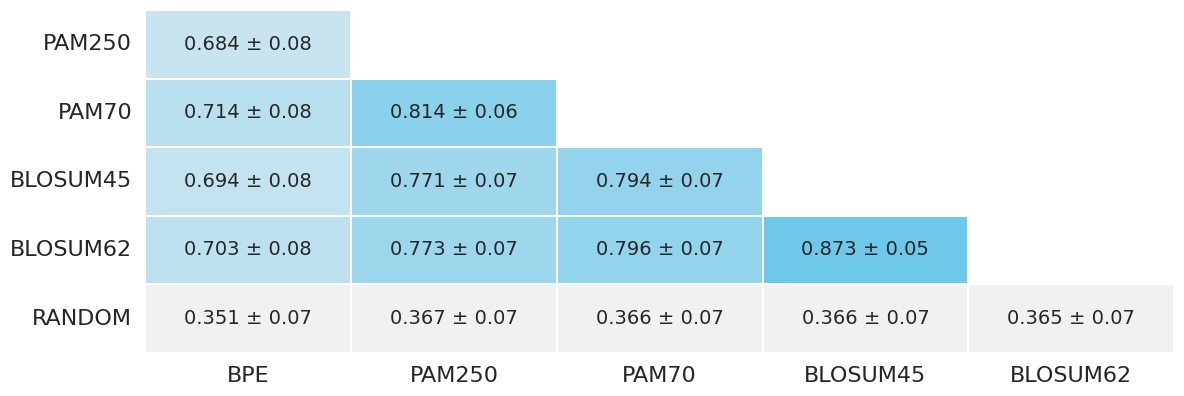

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


n = len(labels)
matrix = np.zeros((n, n))
annotations = np.empty((n,n), dtype=object)


# Fill the matrix with values
for i in range(n):
    for j in range(i):  # Only lower triangle
        label_pair = (labels[i], labels[j])
        if label_pair in pairwise_agreements:
            agg, st = pairwise_agreements[label_pair]
            matrix[i, j] = agg
            annotations[i, j] = str(f"{agg:.3f} ± {st:.2f}")
matrix = matrix[1:,:-1]
annotations = annotations[1:,:-1]
# Create figure with custom size
fig, ax = plt.subplots(figsize=(12, 6))
colors = sns.light_palette("#61c4e8", as_cmap=True)
# Create heatmap
sns.heatmap(matrix, 
            xticklabels=labels[:-1],
            yticklabels=labels[1:],
            mask=~np.tril(np.ones_like(matrix, dtype=bool)),  # Mask upper triangle
            cmap=colors,  # You can change the colormap
            square=True,
            ax = ax,
            annot=annotations,
            fmt="",
            annot_kws={'size': 14},
            linewidths=0.2,
            cbar=False,
            linecolor="white",
            vmin=0.6,
            vmax=0.9) 

# for i in range(n+1):
#         ax.axhline(y=i, color='gray', linewidth=0.5, alpha=0.3, zorder=3)
#         ax.axvline(x=i, color='gray', linewidth=0.5, alpha=0.3, zorder=3)

# for spine in ax.spines.values():
#     spine.set_visible(False)
# Adjust cell sizes
ax.set_aspect(1.0/3)
ax.grid(visible=False)
ax.set_facecolor("white")
# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()



plt.show()